In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn settings
sns.set_theme()
sns.set_context("poster", font_scale=1.4)

from mcmc import metropolis_hastings

from scipy.special import factorial
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [3]:
data_filepath = './../archive/auto-mpg.data'

df = pd.read_csv(data_filepath, delim_whitespace=True, header=None, 
                 names=['mpg', 'cylinders', 'displacement', 'horsepower', 
                        'weight', 'acceleration', 'model_year', 'origin', 'car_name'])

In [4]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [6]:
df[df['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


In [7]:
df = df.replace('?', None)
df.dropna(inplace=True)
df.drop(['car_name'], axis=1, inplace=True)
df['horsepower'] = df['horsepower'].astype(np.float64)

In [8]:
min_max_scaler = MinMaxScaler()
df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']] = min_max_scaler.fit_transform(
    df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']])

In [9]:
df['mpg'] = df['mpg'].round(0).astype(int)

In [10]:
data = df.to_numpy()
data

array([[18.        ,  1.        ,  0.61757106, ...,  0.23809524,
         0.        ,  0.        ],
       [15.        ,  1.        ,  0.72868217, ...,  0.20833333,
         0.        ,  0.        ],
       [18.        ,  1.        ,  0.64599483, ...,  0.17857143,
         0.        ,  0.        ],
       ...,
       [32.        ,  0.2       ,  0.17312661, ...,  0.21428571,
         1.        ,  0.        ],
       [28.        ,  0.2       ,  0.13436693, ...,  0.63095238,
         1.        ,  0.        ],
       [31.        ,  0.2       ,  0.13178295, ...,  0.67857143,
         1.        ,  0.        ]])

In [11]:
def gaussian_proposals(beta, sigma):
    return np.random.normal(beta, sigma, beta.shape)

def log_prior(beta):
    """
    beta[0] = intercept
    beta[1] = cylinders
    beta[2] = displacement
    beta[3] = horsepower
    beta[4] = weight
    beta[5] = acceleration
    beta[6] = model_year
    beta[7] = origin
    """
    sigma = 0.25
    prior_betas = -np.log(sigma * np.sqrt(2*np.pi)) - (beta**2) / (2*sigma**2)
    
    return np.sum(prior_betas)

def log_likelihood(beta, data):
    
    n = len(data)
    
    X = np.append(np.ones((n, 1)), data[:, 1:], axis=1)  # add bias column
    # X = data[:, 1:]
    y = data[:, 0].astype(int)
    lam = np.exp(np.matmul(X, beta))
    
    likelihoods = y * np.log(lam) - lam - np.log(factorial(y))
    
    return np.sum(likelihoods)

In [12]:
beta_init = np.array([0.1, -0.2, -0.2, -0.2, -0.2, 0.2, 0.2, 0.2])
accepted, rejected = metropolis_hastings(beta_init, gaussian_proposals, log_prior, log_likelihood, data, 
                                         proposal_kwargs={'sigma': [0.025]}, samples=1000000, burn_in=0.25)

In [13]:
accepted.shape, rejected.shape

((142888, 8), (607112, 8))

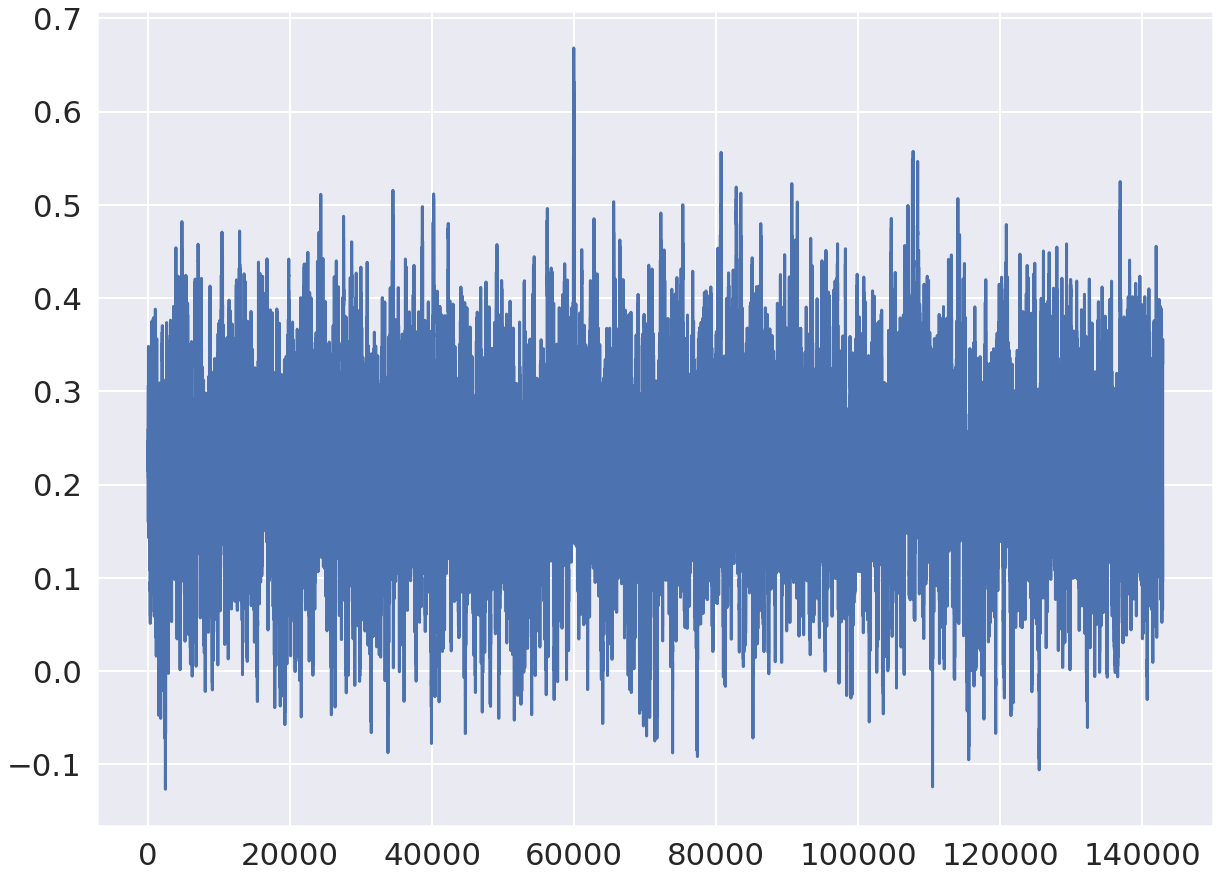

In [15]:
n = accepted.shape[0]
fig, ax = plt.subplots(figsize=(20,15))
plt.plot(range(n), accepted[:,5])
plt.show()

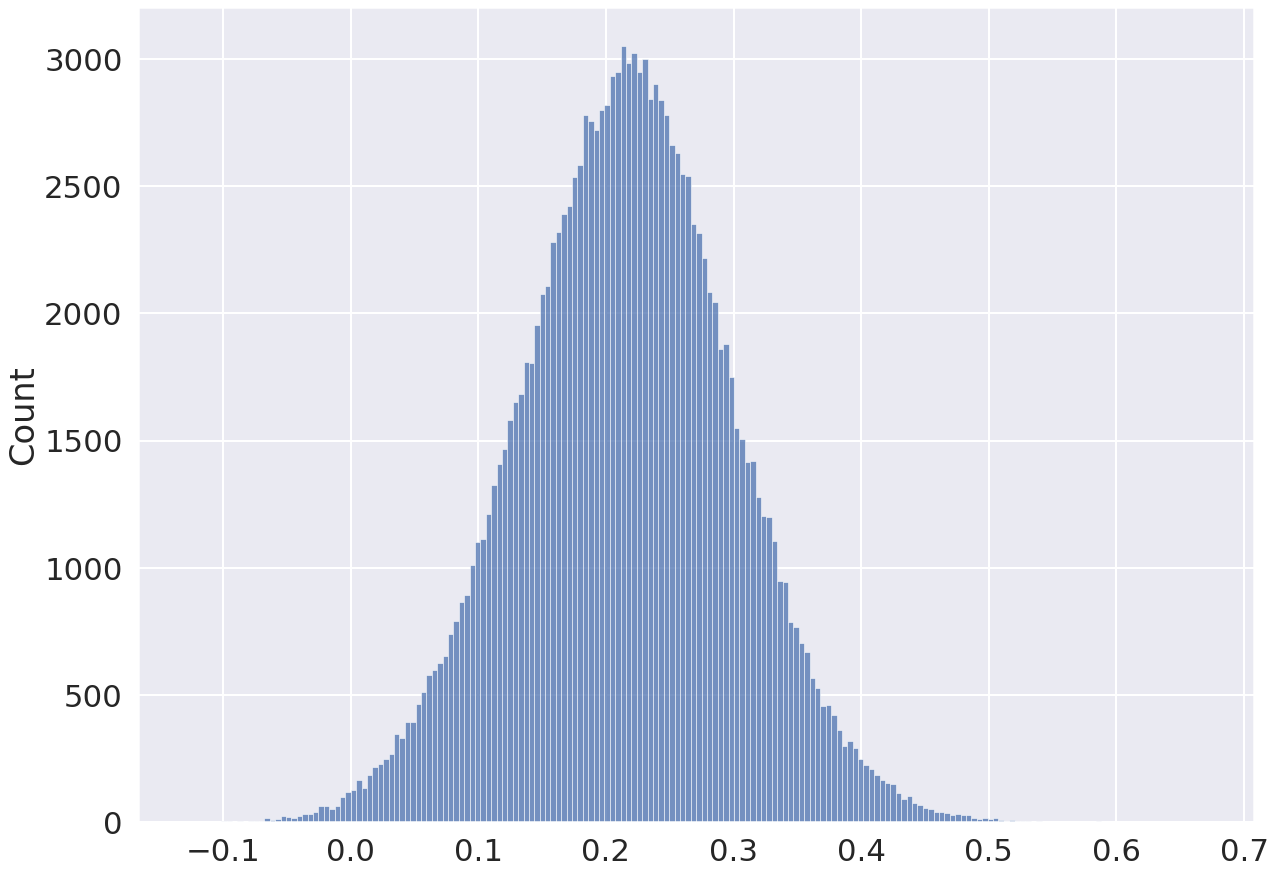

In [16]:
fig, ax = plt.subplots(figsize=(20,15))
sns.histplot(data=accepted[:,5])
plt.show()

In [17]:
beta = np.mean(accepted, axis=0)

In [18]:
beta

array([ 3.11738011, -0.01189703, -0.02643962, -0.03664941, -0.82397622,
        0.21548579,  0.40562613,  0.10022375])

In [19]:
n = len(data)
X = np.append(np.ones((n, 1)), data[:, 1:], axis=1)  # add bias column
# X = data[:, 1:]
y = data[:, 0].astype(int)
lam = np.exp(np.matmul(X, beta))

In [20]:
r2_score(y, lam)

0.8514135096604273

In [21]:
mean_squared_error(y, lam)

9.058316620710045

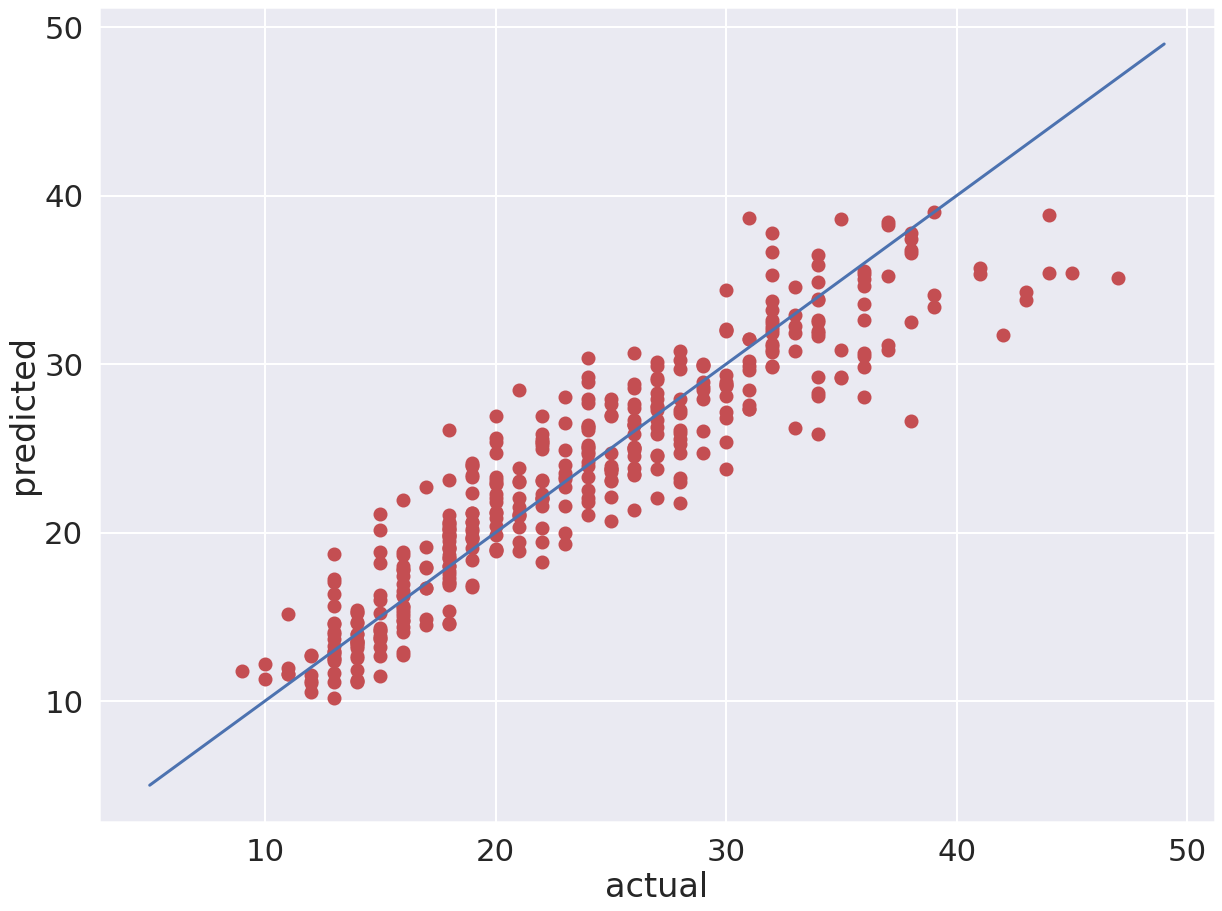

In [22]:
fig, ax = plt.subplots(figsize=(20,15))
plt.plot(range(5, 50), range(5, 50))
plt.scatter(y, lam, c='r')
ax.set_xlabel('actual')
ax.set_ylabel('predicted')
#ax.set_title("Figure 1: Linear Polynomial with Gaussian Noise ($m = 3, b = 2, \sigma = 1$)\n")
plt.show()